# LSTM + Decision Tree Integration Demo

This notebook demonstrates a full pipeline for hard drive failure prediction using both LSTM (deep learning) and Decision Tree (CT) models.

You will:
- Train and test the LSTM model
- Train and test the Decision Tree model on raw data
- Generate LSTM predictions for all drives
- Test a random drive using the LSTM model
- Feed the LSTM results into the Decision Tree and analyze the outcome

**Requirements:**  
- All dependencies installed (see `requirements.txt`)
- Data available in `data`
- LSTM and CT code available in `notebooks/LSTM/smart.py` and `notebooks/CT/CT.py`


In [40]:
# Step 1: Setup and Imports

import os
import sys
from typing import Optional
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import joblib
import json
from datetime import datetime


# Add project root and submodules to sys.path for imports
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, "notebooks/LSTM"))
sys.path.append(os.path.join(project_root, "notebooks/CT"))

import notebooks.LSTM.smart as smart
import notebooks.CT.CT as CT
from notebooks.LSTM.smart import Net

# Set device for torch: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 2: Load the data to train the models

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_existing = True # Change to True to test existing model
days_to_train = 3
days_to_predict = 2
look_back = days_to_train + days_to_predict
path = "../data/data_test"
verbose = True    # Create a single data loader that handles the train/test split properly
print(f'Using device: {device}')

print("🔄 Loading and splitting data to prevent data leakage...")
min_sequence_length = days_to_train + days_to_predict

train_loader, test_loader = smart.load_data(root=path,
                                        train_ratio=0.8, 
                                        min_sequence_length=min_sequence_length,
                                        input_len=days_to_train,
                                        label_len=days_to_predict,
                                        verbose=verbose)


Using device: cuda
🔄 Loading and splitting data to prevent data leakage...
[DriveDataLoader] Found 0 subfolders in ../data/data_test.


Loading CSV files:  17%|█▋        | 1/6 [00:03<00:19,  3.94s/it]

Loaded ../data/data_test\2024-10-01.csv with shape (292679, 15)


Loading CSV files:  33%|███▎      | 2/6 [00:08<00:16,  4.05s/it]

Loaded ../data/data_test\2024-10-02.csv with shape (292648, 15)


Loading CSV files:  50%|█████     | 3/6 [00:12<00:12,  4.00s/it]

Loaded ../data/data_test\2024-10-03.csv with shape (292662, 15)


Loading CSV files:  67%|██████▋   | 4/6 [00:15<00:07,  3.98s/it]

Loaded ../data/data_test\2024-10-04.csv with shape (292694, 15)


Loading CSV files:  83%|████████▎ | 5/6 [00:20<00:04,  4.11s/it]

Loaded ../data/data_test\2024-10-05.csv with shape (292693, 15)


Loading CSV files: 100%|██████████| 6/6 [00:24<00:00,  4.08s/it]

Loaded ../data/data_test\2024-10-06.csv with shape (292683, 15)


[DriveDataLoader] Loaded 1756059 rows from all CSV files. DataFrame shape: (1756059, 15)
[DriveDataLoader] Found 292766 unique drives.
[DriveDataLoader] Filtering drives with minimum 5 days...
[DriveDataLoader] Valid drives (>= 5 days): 292624
[DriveDataLoader] Invalid drives (< 5 days): 142
[DriveDataLoader] Sequence length distribution of invalid drives:
[DriveDataLoader]   {1: np.int64(19), 2: np.int64(28), 3: np.int64(54), 4: np.int64(41)}
[DriveDataLoader] Split: 234099 drives for training, 58525 drives for testing.
[DriveDataLoader] Train ratio: 80.00%
[DriveDataLoader] Final dataset: 1755658 rows from 292624 valid drives.
[DriveDataLoader] Sample TRAIN drive 2GG3UKHD: 6 rows, dates 2024-10-01 to 2024-10-06
[DriveDataLoader] Sample TEST drive ZL2D6FJZ: 6 rows, dates 2024-10-01 to 2024-10-06
[DriveDataLoader] ✅ Verified: No drive overlap between train and test sets.

[DriveDataLoader] 📊 Sample drive verification:
[DriveDataLoader] 🚂 TRAIN sample - Drive 2GG3UKHD:
[DriveDataLoader]

# Step 3: Train the LSTM model

In [42]:

num_features = 12
n_neurons = 4
num_epochs = 1
learning_rate = 0.001

# Check if trained model exists
model_path = 'models/LSTM/lstm_model.pth'

model, model_exists = smart.train_model(features = num_features,
            n_neurons = n_neurons,
            model_path = model_path,
            days_to_predict = days_to_predict,
            days_to_train = days_to_train,
            train_loader = train_loader,
            test_loader = test_loader,
            test_existing = test_existing,
            learning_rate = learning_rate,
            num_epochs = num_epochs)


shape: (torch.Size([3, 3, 12]), torch.Size([3, 2, 12]))
✅ Complete model loaded from models/LSTM/lstm_model.joblib
✅ Model metrics loaded from models/LSTM/lstm_model_metrics.json
Previous best validation loss: 59516.94609691401
Trained model found! Loading and testing...
Testing loaded model...


Model Test Results - Average Loss: 59516.949014


## Step 4: Generate predictions 

In [43]:
# Generate predictions on test set
model.eval()
test_predictions = []
test_targets = []

print("Generating final predictions...")
with torch.no_grad():
    for test_data, test_labels in tqdm(test_loader, desc="Generating predictions"):
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        predictions = model(test_data)
        test_predictions.append(predictions.cpu().numpy())
        test_targets.append(test_labels.cpu().numpy())

# Concatenate all predictions and targets
test_predictions = np.concatenate(test_predictions, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

Generating final predictions...


Generating predictions: 100%|██████████| 19509/19509 [01:24<00:00, 229.87it/s]


# Step 5: Plot the results

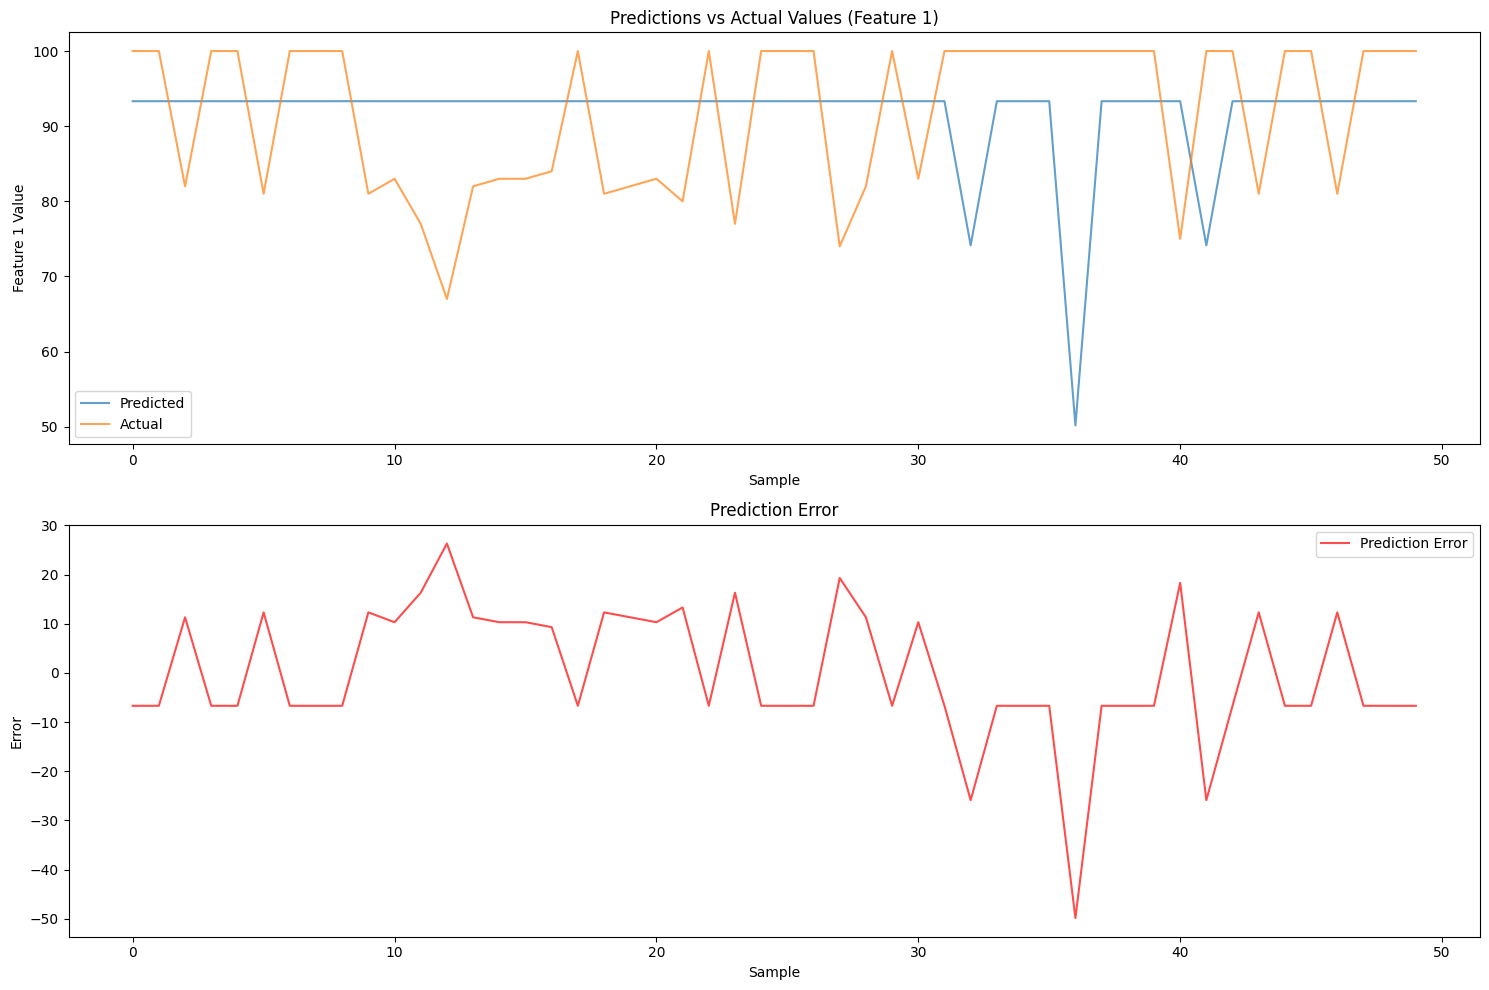

In [52]:
# Plot predictions vs actual values for the first feature
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot first few samples for visualization
num_samples_to_plot = min(50, len(test_predictions))
x = np.arange(num_samples_to_plot)

ax1.plot(x, test_predictions[:num_samples_to_plot, 0, 0], label='Predicted', alpha=0.7)
ax1.plot(x, test_targets[:num_samples_to_plot, 0, 0], label='Actual', alpha=0.7)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Feature 1 Value")
ax1.set_title("Predictions vs Actual Values (Feature 1)")
ax1.legend()

# Plot prediction error
error = test_predictions[:num_samples_to_plot, 0, 0] - test_targets[:num_samples_to_plot, 0, 0]
ax2.plot(x, error, label='Prediction Error', color='red', alpha=0.7)
ax2.set_xlabel("Sample")
ax2.set_ylabel("Error")
ax2.set_title("Prediction Error")
ax2.legend()
plt.tight_layout()

## Step 4: Train and Test the Decision Tree (CT) on Raw Data

We will now train and test the Decision Tree model using the raw SMART data.

### Step 4.1: Load the data to train the Decision Tree model

In [56]:
data_path = "../data/data_test"
data = CT.importdata(data_path)

# Split dataset and apply SMOTE
X, Y, X_train_res, X_test, y_train_res, y_test = CT.splitdataset(data)

Processing CSV files:  17%|█▋        | 1/6 [00:07<00:38,  7.71s/it]


KeyboardInterrupt: 

In [48]:
# Run standard CT analysis on raw data
ct_data_path = lstm_data_path  # Use the same data as LSTM

# The CT pipeline expects a features file. For raw SMART, set feature_selection_method='smart_only'
ct_results = CT.analyze_lstm_predictions_with_ct(
    lstm_features_path=None,  # None means use raw data
    ground_truth_path=ct_data_path,
    feature_selection_method='smart_only',  # Only use SMART features
    output_dir="ct_raw_analysis"
)
print("CT Results on Raw Data:")
print(ct_results)

🔬 Starting CT analysis of LSTM predictions...


TypeError: stat: path should be string, bytes, os.PathLike or integer, not NoneType

## Step 5: Generate LSTM Predictions for All Drives

We will use the trained LSTM model to generate predictions for all drives, and export features for CT analysis.

In [ ]:
# Generate LSTM predictions and export features for CT
ct_features_output_dir = "ct_lstm_features"
if hasattr(smart, "export_for_ct_analysis"):
    predictions_df, ct_features_df = smart.export_for_ct_analysis(
        model_path=lstm_model_path,
        dataset_path=lstm_data_path,
        output_dir=ct_features_output_dir
    )
    print(f"Exported {len(ct_features_df)} drive-level features for CT analysis.")
else:
    print("❌ export_for_ct_analysis function not found in smart.py. Please generate LSTM features manually.")

## Step 6: Test a Random Drive with the LSTM Model

Let's select a random drive from the dataset, run it through the LSTM model, and display the prediction.

In [ ]:
# Load the list of drives
all_serials = []
for f in os.listdir(lstm_data_path):
    if f.endswith('.csv'):
        try:
            df = pd.read_csv(os.path.join(lstm_data_path, f), usecols=['serial_number'])
            all_serials.extend(df['serial_number'].unique())
        except Exception as e:
            print(f"Error reading {f}: {e}")
all_drives = list(set(all_serials))
random_drive = random.choice(all_drives)
print(f"Randomly selected drive: {random_drive}")

# Run the LSTM model on this drive (assuming such a function exists)
if hasattr(smart, "predict_drive"):
    random_drive_pred = smart.predict_drive(
        model_path=lstm_model_path,
        drive_serial=random_drive,
        data_path=lstm_data_path
    )
    print(f"LSTM prediction for drive {random_drive}: {random_drive_pred}")
else:
    print("❌ predict_drive function not found in smart.py. Please test a drive manually.")

## Step 7: Feed LSTM Results into the Decision Tree (CT)

Now, we will use the LSTM-generated features as input to the Decision Tree model and analyze the results.

In [ ]:
# Path to the exported LSTM features for CT
lstm_features_path = os.path.join(ct_features_output_dir, "ct_features.csv")

# Run CT analysis on LSTM features
ct_lstm_results = CT.analyze_lstm_predictions_with_ct(
    lstm_features_path=lstm_features_path,
    ground_truth_path=lstm_data_path,
    feature_selection_method='all',  # Use all features (LSTM + SMART)
    output_dir="ct_lstm_analysis"
)
print("CT Results on LSTM Features:")
print(ct_lstm_results)

## Step 8: Visualize and Interpret Results

Let's visualize the feature importance and summarize the pipeline's performance.

In [ ]:
import matplotlib.pyplot as plt

# Load feature importance from CT results
importance_df = pd.DataFrame(ct_lstm_results['feature_importance'])
top_features = importance_df.sort_values('gini_importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['gini_importance'])
plt.xlabel('Gini Importance')
plt.title('Top 10 Most Important Features (LSTM + SMART)')
plt.gca().invert_yaxis()
plt.show()

print("Pipeline complete! You have now trained, tested, and integrated LSTM and Decision Tree models for hard drive failure prediction.")